# 02_titanic
Autor: Carlos Wong <br/>
Fecha: 2022_02_08 <br/>
Tipo de problema: CLASIFICACIÓN <br/>
Entradas: 'train' kaggle competition (titanic) <br/>
Salidas: Submission ('PassengerId','Survived')  <br/>
Propósito: Práctica de análisis, visualización, entrenamiento, predicción y documentación

## 1. Librerías + Descarga de datos

In [3799]:
# librerías estándar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3800]:
import warnings
warnings.filterwarnings("ignore")

In [3801]:
# librerías sklearn
# Se descargan librerías para realizar diferentes pruebas
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV 
from sklearn.compose import make_column_transformer, ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.preprocessing import KBinsDiscretizer 
from sklearn.preprocessing import FunctionTransformer,PowerTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer, KNNImputer

In [3802]:
# librerías de modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [3803]:
train = pd.read_csv(r'./datasets/train.csv', sep=',')
test = pd.read_csv(r'./datasets/test.csv', sep=',')

In [3804]:
X_train = train.drop(['PassengerId','Survived'], axis=1)
y_train = train['Survived']
X_test = test.drop(['PassengerId'], axis=1)

## 2. EDA 

In [3805]:
X_train.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3806]:
X_test.head(3)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


## 3. Feature Engineering

Preprocessing with Pipe:
1. Name: Extract 'Title' -> Group categories in 'Mr','Mrs','Miss','Master'
2. Title: Se agrupan en clases
3. Cabin (Imputation NaN=0) -> hasCabin (Transformation, (any_value != 0) == 1)
4. Ticket, Name: Drop
5. Cabin: Se comprueba Cabin NO aporta señal.  Se descarta. 
6. Parch,SibSp (Transformation, (any_value > 0) == 1)

Preprocessing with Pipeline:
1. Embarked (Imputation Categorical) -> Sex, Embarked, Pclass (OneHot, drop first)
2. Age, Fare (Imputation Numerical KNN) -> Age, Fare (Binning, StandardScaler)
3. Pclass: Remainder, sin cambios, variable numérica ordinal
4. Sex: Muy alta correlación con Title, se elimina 'Sex'

Modelo:
1. Random Forest

In [3807]:
csv_name = 'MrsOut'

## Pipe

In [3808]:
def extract_title (df_x,colname):
    df_x['Title'] = df_x[colname].str.extract(' ([A-Za-z]+)\.', expand=False)
    df_x.drop([colname], 1, inplace=True)
    return df_x

In [3809]:
def map_title (df_x):
    dct1 = dict.fromkeys(['Col','Jonkheer','Rev','Major','Capt','Sir','Don','Mr','Dr'],'Mr')
    dct2 = dict.fromkeys(['Countess','Mme','Lady','Dona','Mrs'],'Mrs')
    dct3 = dict.fromkeys(['Mlle','Ms','Miss'],'Miss')
    dct4 = dict.fromkeys(['Master'],'Master')
    dct = {**dct1,**dct2, **dct3, **dct4}
    df_x['Title'] = df_x['Title'].map(dct)
    return df_x

In [3810]:
def map_cabin (df_x):
    df_x['Cabin'] = df_x['Cabin'].fillna(0)
    df_x['hasCabin'] = df_x['Cabin'].apply(lambda x: 0 if x==0 else 1)
    df_x.drop(['Cabin'], 1, inplace=True)
    return df_x

In [3811]:
def parch_sibsp (df_x):
    df_x['Parch'] = df_x['Parch'].apply(lambda x: 0 if x == 0 else 1)
    df_x['SibSp'] = df_x['SibSp'].apply(lambda x: 0 if x == 0 else 1)
    return df_x

In [3812]:
def drop_col (df_x,*args):
    df_x = df_x.drop(*args, axis=1)
    return df_x

In [3813]:
# Se aplican las mismas transformaciones a los conjuntos train y test
# Se elimina 'Sex' porque tiene muy alta correlación con 'Title'
# Se elimina hasCabin porque no da señal al modelo
to_drop = ['Ticket','hasCabin','Sex']
X_train = X_train.pipe(extract_title,'Name').pipe(map_title).pipe(map_cabin).pipe(parch_sibsp).pipe(drop_col,to_drop)
X_test  = X_test.pipe(extract_title,'Name').pipe(map_title).pipe(map_cabin).pipe(parch_sibsp).pipe(drop_col,to_drop)
X_train.head(3)

,Pclass,Age,SibSp,Parch,Fare,Embarked,Title
0,3,22.0,1,0,7.2500,S,Mr
1,1,38.0,1,0,71.2833,C,Mrs
2,3,26.0,0,0,7.9250,S,Miss


## Pipeline

In [3814]:
categoric = ['Embarked','Title']  # 'Sex',
numeric_1 = ['Age']
numeric_2 = ['Fare']
numeric_3 = ['SibSp','Parch']

In [3815]:
imp_cate = SimpleImputer(strategy='most_frequent')
imp_num1 = KNNImputer(n_neighbors=7, weights='uniform', metric='nan_euclidean')
scaler_1 = StandardScaler()
scaler_2 = StandardScaler()
bin_num1 = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
bin_num2 = KBinsDiscretizer(n_bins=11, encode='ordinal', strategy='uniform')
encoder1 = OneHotEncoder(handle_unknown="ignore", sparse=False, drop='first')
power = PowerTransformer(method='yeo-johnson', standardize=True)

In [3816]:
categoric_transformer = Pipeline(
    steps=[("imp_cat", imp_cate), 
           ("encoder", encoder1)]
)

In [3817]:
numeric_transformer1 = Pipeline(
    steps=[("imputer", imp_num1), 
           ("binner1", bin_num1),
           ("scaler",  scaler_1)]
)

In [3818]:
numeric_transformer2 = Pipeline(
    steps=[
        ("imputer", imp_num1), 
        ("binner2", bin_num2),
        ("scaler",  scaler_2)]
)

In [3819]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categoric_transformer, categoric),
        ("num1", numeric_transformer1, numeric_1),
        ("num2", numeric_transformer2, numeric_2),
    ], remainder='passthrough'
)

In [3820]:
# 'fit_transform' de conjunto train
a = preprocessor.fit_transform(X_train)
X = pd.DataFrame(a,columns=preprocessor.get_feature_names_out())

In [3821]:
# sólo 'transform' de conjunto test
b = preprocessor.transform(X_test)
test_X = pd.DataFrame(b,columns=preprocessor.get_feature_names_out())

In [3822]:
X.head(2)

,cat__Embarked_Q,cat__Embarked_S,cat__Title_Miss,cat__Title_Mr,cat__Title_Mrs,num1__Age,num2__Fare,remainder__Pclass,remainder__SibSp,remainder__Parch
0,0.0,1.0,0.0,1.0,0.0,-0.357914,-0.347772,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.873365,0.674884,1.0,1.0,0.0


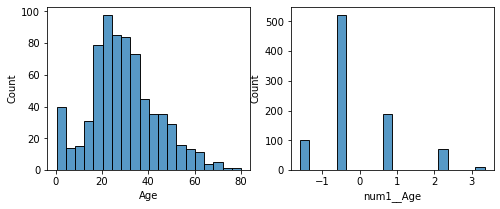

In [3823]:
plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
sns.histplot(X_train.Age)
plt.subplot(1,2,2)
sns.histplot(X.num1__Age)
plt.show()

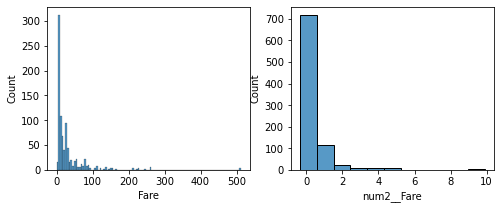

In [3824]:
plt.figure(figsize = (8,3))
plt.subplot(1,2,1)
sns.histplot(X_train.Fare)
plt.subplot(1,2,2)
sns.histplot(X.num2__Fare)
plt.show()

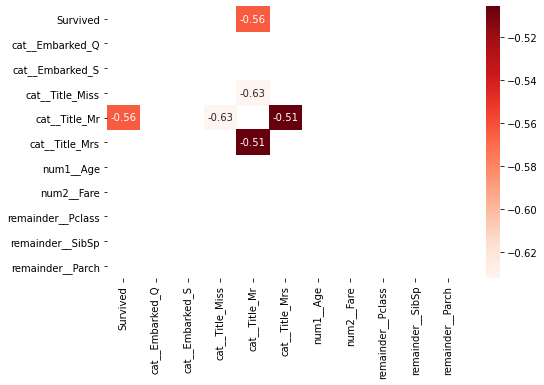

In [3825]:
# Se muestra la matriz de correlaciones (que incluye variable objetivo) con las
# correlaciones que superan el (+/-) 50%
Xcorr = pd.concat([y_train, X], axis=1).corr()
filteredX = Xcorr[((Xcorr >= .5) | (Xcorr <= -.5)) & (Xcorr !=1.000)]
plt.figure(figsize=(8,5))
sns.heatmap(filteredX, annot=True, cmap="Reds")
plt.show()

In [3826]:
# Se elimina 'cat__Title_Miss' en train y test por alta correlación con 'cat__Title_Mr'
X      = X.drop(['cat__Title_Miss','cat__Title_Mrs'], axis=1)
test_X = test_X.drop(['cat__Title_Miss','cat__Title_Mrs'], axis=1)

## 4. Random Forest

In [3827]:
model = RandomForestClassifier(max_depth=12, criterion='entropy', random_state=99)  # 0.8641975308641975
model.fit(X, y_train)
results = model.score(X, y_train)
print(results)

0.8608305274971941


In [3828]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
pipeline = make_pipeline(model)
cv_results = cross_val_score (pipeline,                   # Pipeline
                              X,                          # Feature matrix
                              y_train,                    # Target vector
                              cv=skf,
                              scoring="accuracy").mean()  # Cross-validation technique
cv_results

0.8126966292134832

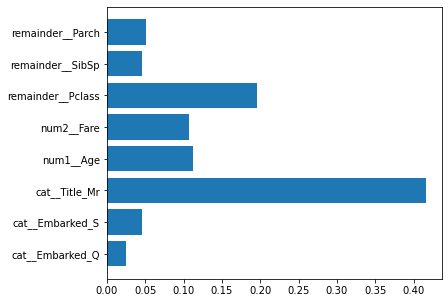

In [3830]:
plt.figure(figsize=(6,5))
plt.barh(y=X.columns, width=model.feature_importances_)
plt.show()

In [3831]:
features = test.drop(['PassengerId'], axis=1)
PassengerId = test.PassengerId

In [3832]:
predictions = model.predict(test_X)

In [3833]:
submission = pd.DataFrame({
    "PassengerId": PassengerId,
    "Survived": predictions
    })

In [3834]:
submission.to_csv(f'./submissions/titanic_rf_{csv_name}_{format(pd.datetime.now().strftime("%Y%m%d-%H%M"))}.csv', index=False) 

In [3835]:
# sc:0.86419 kggl_sc:0.78229 titanic_rf_base_
# sc:0.86307 kggl_sc:0.78947 titanic_rf_MissOut_
# sc:0.86083 kggl_sc:0.78947 titanic_rf_MrsOut_